## Project Numerical Imaging  : correction of underwater images

### Transfromation from RGB to LAlphaBeta space

* __Hypothesis__ 

- gray world assumption 
- uniform illumination : intensity is the same in each point of the image 
- objects are Lambertian : do not depend on the point of vue (angle)

In [5]:
im_dir = './'

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
#import skimage
%matplotlib inline
os.chdir(os.getcwd())

### Test with cv2

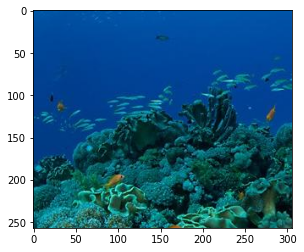

NameError: name 'imLabCorrect' is not defined

In [8]:
im = cv2.imread(im_dir + 'coral.jpg')
imRGB = imLab = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(imRGB)
plt.show()

imLab = cv2.cvtColor(im, cv2.COLOR_BGR2LAB)


l,a,b = cv2.split(imLab)
#transformations to dot but do not work with cv2 in Lab space
a = a - np.median(a)
b = b - np.median(b)


#imLabCorrect = cv2.merge((l,a,b))
rgb_image = cv2.cvtColor(imLabCorrect, cv2.COLOR_LAB2RGB)
plt.imshow(rgb_image)
plt.show()

## Our function

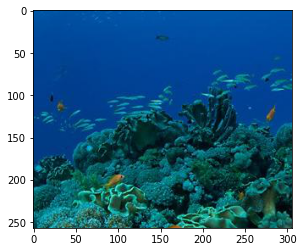

In [10]:
def check_input(arr):
    """Check the shape of the array and convert it to
    floating point representation.
    """

    if arr.shape[-1] != 3:
        raise ValueError("Input array must have a shape == (..., 3)), "
                         f"got {arr.shape}")

    return arr

im = plt.imread(im_dir + 'coral.jpg')
im = check_input(im)
plt.imshow(im)
plt.show()

### Non linearity (gamma) correction

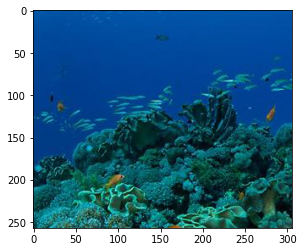

In [11]:
def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255]
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)


im = adjust_gamma(im, gamma= 1)
#im = cv2.resize(dsize = (im.shape[1],im.shape[0]//4), src = im )
# normalize
im = im.astype(np.float)/ 255
plt.imshow(im)
plt.show()


In [12]:
print('max,min :',im.max(), im.min())

max,min : 1.0 0.0


In [13]:
Txyz = np.array([[0.5141, 0.3239, 0.1604],
                 [0.2651, 0.6702, 0.0641],
                 [0.0241, 0.1288, 0.8444]])

Tlms = np.array([[0.3897, 0.6890, 0.0787],
                 [-0.2298, 1.1834, 0.0464],
                 [0.0000, 0.0000, 1.0000]])
#D = Txyz@Tlms

Tpca1 = np.array([[1/np.sqrt(3), 0, 0],
                [0, 1/np.sqrt(6), 0],
                [0, 0, 1/np.sqrt(2)]])

Tpca2 = np.array([[1, 1, 1],
                 [1, 1, -2],
                  [1, -1, 0]])
Tpca = Tpca1 @ Tpca2
# RGB to Lab

imLab = np.log(im @ Txyz.T @ Tlms.T)@ Tpca2.T @ Tpca1.T

#imLab = np.log(im @ Txyz.T @ Tlms.T) @ Tpca.T

# color correction
# only alpha and beta channel : substract channel wise median

imLabCorrec = np.zeros(shape = im.shape)
imLabCorrec [:,:,0] = imLab[:,:,0] 
imLabCorrec [:,:,1] = imLab[:,:,1] - np.median(imLab[:,:,1])
imLabCorrec[:,:,2] = imLab[:,:,2] - np.median(imLab[:,:,2])


print('median alpha channel:', np.median(imLab[:,:,1]))
print('median beta channel:', np.median(imLab[:,:,2]))


# Lab to RGB
imLabInv = np.exp(imLabCorrec @ np.linalg.inv(Tpca.T))@ np.linalg.inv(Txyz.T @ Tlms.T)

median alpha channel: -0.17090656767136037
median beta channel: -0.19140950876099816


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


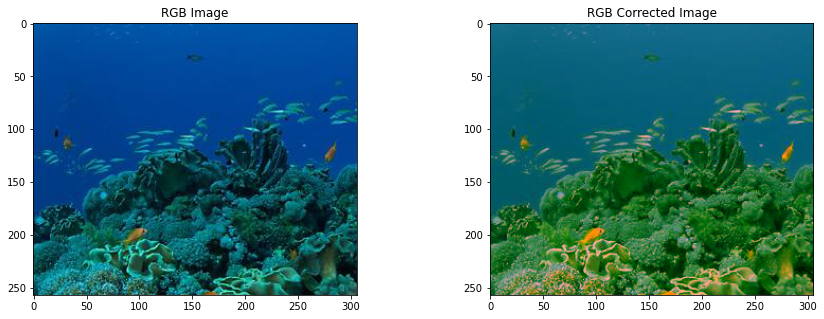

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].imshow(im)
ax[0].set_title('RGB Image')
ax[1].imshow(imLabInv)#Inv)
ax[1].set_title('RGB Corrected Image')
plt.show()

## αβ diagram

Text(0, 0.5, 'β')

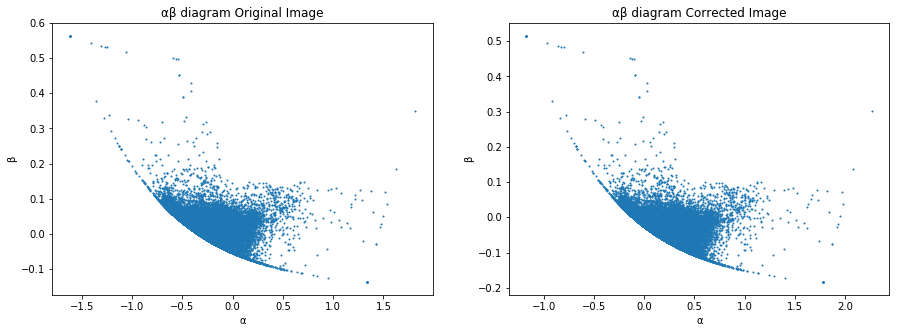

In [162]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].scatter(imLab[:,:,1].flatten(),imLab[:,:,2].flatten(), s = 1)
ax[0].set_title('αβ diagram Original Image')
ax[0].set_xlabel('α')
ax[0].set_ylabel('β')
ax[1].scatter(imLabCorrec[:,:,1].flatten(),imLabCorrec[:,:,2].flatten(), s = 1)
ax[1].set_title('αβ diagram Corrected Image')
ax[1].set_xlabel('α')
ax[1].set_ylabel('β')


## Luminance histogram

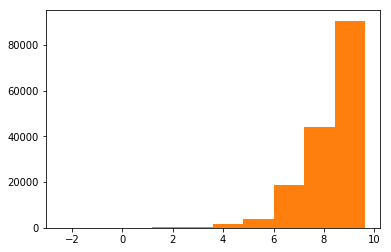

In [94]:
fig = plt.figure()
plt.hist(imLab[:,:,0].flatten())
plt.hist(imLab_correc[:,:,0].flatten())
plt.show()

## Brouillon

In [116]:
#Tpca = Tpca1@Tpca2

def RGB2XYZ(im):
    
    return im @ Txyz.T

def XYZ2LMS(im):
    
    return im @ Tlms.T

def LMS2Lab(im):
    
    return np.log(im) @ Tpca1.T @ Tpca2.T

def Lab2LabCorrec(im):
    
    imLab_correc = np.zeros(shape = im.shape)
    imLab_correc [:,:,0] = imLab[:,:,0]
    imLab_correc [:,:,1] = imLab[:,:,1] - np.median(imLab[:,:,1])
    imLab_correc[:,:,2] = imLab[:,:,2] - np.median(imLab[:,:,2])
    
    return imLab

def Lab2RGB(im):
    return np.exp(im @ np.linalg.inv(Tpca.T))@ np.linalg.inv(Txyz.T @ Tlms.T)

imXYZ = RGB2XYZ(im)
imLMS = XYZ2LMS(imXYZ)
imLab = LMS2Lab(imLMS)
imLabCorrec = Lab2LabCorrec(imLab)
RGBCorrec = Lab2RGB(imLab)

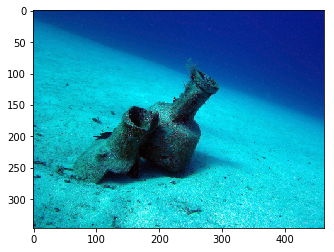

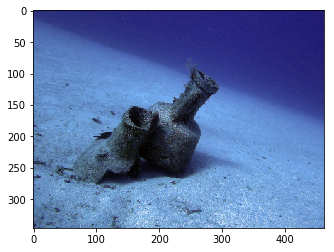

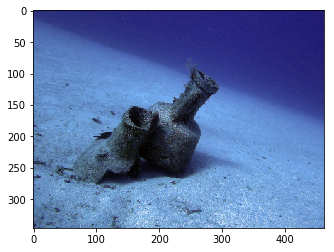

In [118]:
plt.imshow(np.uint8(im))
plt.show()
im_correc = RGB2XYZ(im, Txyz, Tlms, Tpca )  
plt.imshow(np.uint8(im_correc))
plt.show()
plt.imshow(np.uint8(im@Txyz.T))
plt.show()


- chromatic components changes moving their distributions around the white point (white balancing) 